Github link - https://github.com/Rjshrestha/MSIT3103-GenAI-assignments.git

Assignment 1: Foundations Reflection Discriminative vs Generative AI Models This notebook explores two fundamental AI model types:

Discriminative model: Logistic Regression (PyTorch)
Generative model: Simple GAN (PyTorch)
We train both models on the MNIST dataset and compare their behavior, training dynamics, and output quality.

In [1]:
import sys
!{sys.executable} -m pip install scikit-learn

# Core libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

# For Logistic Regression evaluation
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay


Explanation: We load the MNIST dataset (28x28 grayscale digits) and normalize the images to [-1,1].
We also visualize 8 sample images to understand the data.

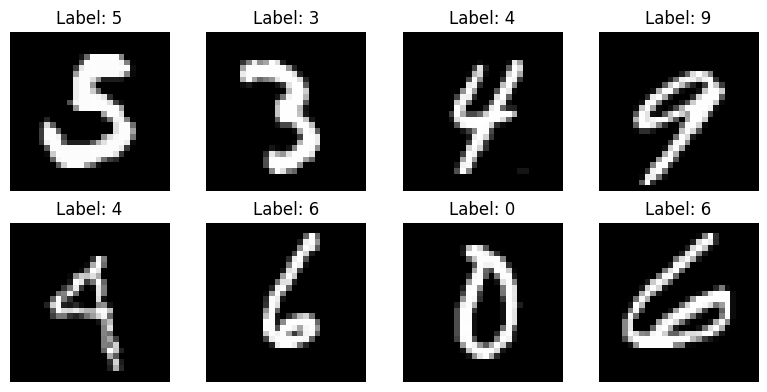

In [2]:
# Transforming MNIST images to tensors and normalizing
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Loading MNIST datasets
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, transform=transform, download=True)

batch_size = 128
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Visualizing 8 sample images
examples = iter(train_loader)
images, labels = next(examples)

plt.figure(figsize=(8,4))
for i in range(8):
    plt.subplot(2,4,i+1)
    plt.imshow(images[i].squeeze(), cmap='gray')
    plt.title(f"Label: {labels[i].item()}")
    plt.axis('off')
plt.tight_layout()
plt.show()

Logistic Regression Model

Explanation:

Logistic Regression is a discriminative model.
It directly maps input features to class probabilities.
CrossEntropyLoss is used for multi-class classification.
We use Adam optimizer for weight updates.

In [3]:
# Defining Logistic Regression model in PyTorch
input_dim = 28*28  # Flattened image size
num_classes = 10   # digits 0-9

class LogisticRegressionModel(nn.Module):
    def __init__(self, input_dim, num_classes):
        super().__init__()
        self.linear = nn.Linear(input_dim, num_classes)
    def forward(self, x):
        return self.linear(x)

model = LogisticRegressionModel(input_dim, num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
num_epochs = 5


Logistic Regresion Training

Explanation:

Each epoch, the model processes all training data.
We flatten images from 28x28 to 784 features.
We compute loss, backpropagate, and update weights.
Accuracy is tracked to monitor training progress.

In [4]:
# Training loop
for epoch in range(num_epochs):
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in train_loader:
        images = images.view(-1, 28*28)
        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    print(f"Epoch [{epoch+1}/{num_epochs}] Loss: {running_loss/len(train_loader):.4f}, Accuracy: {100*correct/total:.2f}%")


Epoch [1/5] Loss: 0.5341, Accuracy: 85.59%
Epoch [2/5] Loss: 0.3383, Accuracy: 90.25%
Epoch [3/5] Loss: 0.3149, Accuracy: 90.94%
Epoch [4/5] Loss: 0.3038, Accuracy: 91.32%
Epoch [5/5] Loss: 0.2956, Accuracy: 91.62%


Logistic Regression Evaluation

Explanation: 
- We evaluate model performance on unseen test data.  
- Classification report gives precision, recall, F1-score per class.  
- Confusion matrix shows which digits are commonly misclassified.

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.97      0.96       980
           1       0.97      0.97      0.97      1135
           2       0.94      0.87      0.91      1032
           3       0.90      0.91      0.91      1010
           4       0.96      0.88      0.92       982
           5       0.88      0.87      0.87       892
           6       0.92      0.95      0.94       958
           7       0.92      0.92      0.92      1028
           8       0.87      0.89      0.88       974
           9       0.86      0.92      0.89      1009

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000



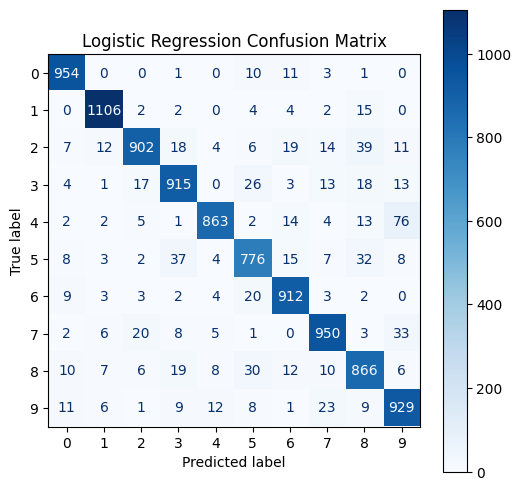

In [5]:
# Collecting predictions for test set
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.view(-1, 28*28)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        all_preds.extend(predicted.numpy())
        all_labels.extend(labels.numpy())

# Classification report
print("Classification Report:")
print(classification_report(all_labels, all_preds))

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(range(10)))
fig, ax = plt.subplots(figsize=(6,6))
disp.plot(ax=ax, cmap='Blues')
plt.title('Logistic Regression Confusion Matrix')
plt.show()

GAN Model Definition

Explanation:

GAN has two networks: Generator (creates fake images) and Discriminator (classifies real vs fake).
Binary cross-entropy loss is used for GAN training.
Adam optimizer is used for both networks.

In [6]:
# Generator
class Generator(nn.Module):
    def __init__(self, noise_dim=100):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(noise_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 784),
            nn.Tanh()
        )
    def forward(self, z):
        return self.model(z)

# Discriminator
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(784, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )
    def forward(self, x):
        return self.model(x)

# Initializing models
noise_dim = 100
generator = Generator(noise_dim)
discriminator = Discriminator()

criterion = nn.BCELoss()
g_optimizer = torch.optim.Adam(generator.parameters(), lr=0.0002)
d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=0.0002)
num_epochs = 20
d_losses = []
g_losses = []

GAN Training Code
 
- Each epoch, discriminator learns to distinguish real vs fake images.  
- Generator tries to fool the discriminator.  
- Losses for both are recorded for plotting training dynamics.

In [7]:
for epoch in range(num_epochs):
    for real_images, _ in train_loader:
        batch_size = real_images.size(0)
        real_images = real_images.view(batch_size, -1)

        real_labels = torch.ones(batch_size,1)
        fake_labels = torch.zeros(batch_size,1)

        # --- Discriminator ---
        outputs = discriminator(real_images)
        d_loss_real = criterion(outputs, real_labels)

        noise = torch.randn(batch_size, noise_dim)
        fake_images = generator(noise)
        outputs = discriminator(fake_images.detach())
        d_loss_fake = criterion(outputs, fake_labels)

        d_loss = d_loss_real + d_loss_fake
        d_optimizer.zero_grad()
        d_loss.backward()
        d_optimizer.step()

        # --- Generator ---
        noise = torch.randn(batch_size, noise_dim)
        fake_images = generator(noise)
        outputs = discriminator(fake_images)
        g_loss = criterion(outputs, real_labels)
        g_optimizer.zero_grad()
        g_loss.backward()
        g_optimizer.step()

    d_losses.append(d_loss.item())
    g_losses.append(g_loss.item())
    print(f"Epoch [{epoch+1}/{num_epochs}] D Loss: {d_loss.item():.4f} G Loss: {g_loss.item():.4f}")

Epoch [1/20] D Loss: 0.0832 G Loss: 7.5599
Epoch [2/20] D Loss: 0.0615 G Loss: 5.3044
Epoch [3/20] D Loss: 0.5128 G Loss: 3.2185
Epoch [4/20] D Loss: 0.7239 G Loss: 2.8741
Epoch [5/20] D Loss: 0.4058 G Loss: 1.8678
Epoch [6/20] D Loss: 0.3644 G Loss: 3.9874
Epoch [7/20] D Loss: 0.0866 G Loss: 4.5499
Epoch [8/20] D Loss: 0.1049 G Loss: 4.3939
Epoch [9/20] D Loss: 0.3105 G Loss: 4.4803
Epoch [10/20] D Loss: 0.2099 G Loss: 3.9522
Epoch [11/20] D Loss: 0.1176 G Loss: 6.0072
Epoch [12/20] D Loss: 0.2495 G Loss: 4.4444
Epoch [13/20] D Loss: 0.3420 G Loss: 5.3554
Epoch [14/20] D Loss: 0.0705 G Loss: 5.1863
Epoch [15/20] D Loss: 0.3160 G Loss: 4.8525
Epoch [16/20] D Loss: 0.2604 G Loss: 3.9957
Epoch [17/20] D Loss: 0.1696 G Loss: 5.1574
Epoch [18/20] D Loss: 0.2014 G Loss: 7.1224
Epoch [19/20] D Loss: 0.1453 G Loss: 3.7510
Epoch [20/20] D Loss: 0.2418 G Loss: 6.9849


In [ ]:
GAN Loss Plot

Loss curves show GAN training stability.
Diverging or oscillating losses indicate instability or mode collapse.

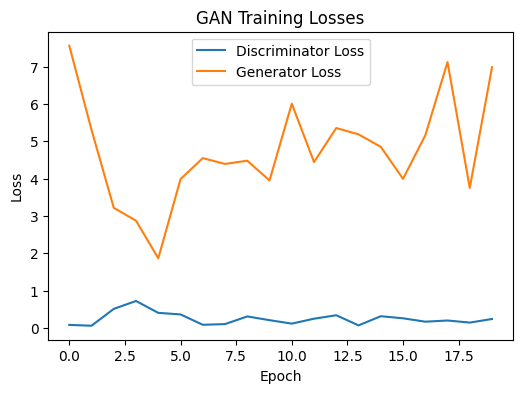

In [8]:
plt.figure(figsize=(6,4))
plt.plot(d_losses, label='Discriminator Loss')
plt.plot(g_losses, label='Generator Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('GAN Training Losses')
plt.legend()
plt.show()

GAN Generated Images

Visualizes 16 images generated by the GAN after training.
Helps compare the quality and diversity of generated digits.

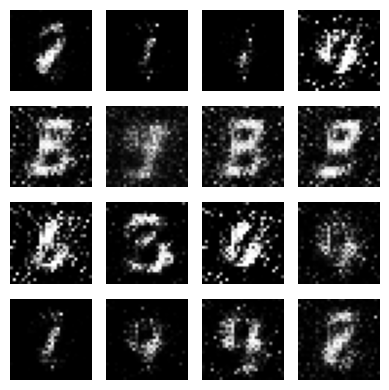

In [9]:
noise = torch.randn(16, noise_dim)
generated_images = generator(noise).view(-1, 28, 28)

plt.figure(figsize=(4,4))
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.imshow(generated_images[i].detach(), cmap='gray')
    plt.axis('off')
plt.tight_layout()
plt.show()

Reflections

Discriminative vs Generative:

Logistic Regression is easy to train and gives clear accuracy metrics.
GAN is harder to train, unstable, but can generate realistic synthetic data.
Training dynamics:

Logistic Regression converges quickly with stable loss.
GAN loss curves oscillate; D/G losses need to balance for good results.
Applications:

Logistic Regression: classification tasks (e.g., digit recognition).
GAN: image generation, data augmentation, creative AI applications.